In [27]:
#Import Statements
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output 
from IPython.display import Image
import os
from os import path
import pandas as pd
from scipy.signal import find_peaks
import glob
import math

In [28]:
#Functions

def fits_data_to_3d_array(file_list): 
    '''
    Takes in a list of fits files and converts data into a 3d array
    Parameters:
        file_list (list): List containing paths of FITS files to convert.
    Returns:
        final_array: 3d array of data from each fits file.
    '''    
    for i, file in enumerate(file_list):
        with fits.open(file) as hdu:
            if i==0:  #If first iteration, create array with correct shape of data
                final_array = np.zeros((len(file_list), *hdu[0].data.shape))
            final_array[i,:,:] = hdu[0].data
    return final_array

#Creates a median combine of a 3d array
def median_combine(frame_array_3d):
    master_frame = np.median(frame_array_3d,axis=0) #takes median along the 'file_index' axis
    return master_frame
 
def save_array_to_fits_file(array, new_file_name):
    '''
    Saves a 2d array of pixel data to a FITS file.
    Parameters:
    array(2d): 2d array containing pixel values.
    new_file_name (path): location, name of FITS file to be saved.
    '''  
    hdu = fits.PrimaryHDU(data = array)
    hdul = fits.HDUList([hdu])
    hdul.writeto(new_file_name,overwrite=True)


def create_file_list(data_directory, file_name_to_glob, show_list = False):
    
    '''
    This creates a list of all FITS files that will be used.
    
    Parameters:
    data_directory : path to data folder
    file_name_to_glob : name of file containing data (ex.: spectrograph_flats_20s_)
                        This will glob together all files containing this keywords.
    show_list : Show file list for verification.
    '''
    file_list = glob.glob(os.path.join(data_directory, '*' + file_name_to_glob + '*'))
    
    if show_list: 
        for file in file_list: print(file)
            
    return file_list

def cut_pixel_data_array(pixel_data_array, y_pixel_min, y_pixel_max):
    '''
    Returns an array of pixel data, cut to a specified vertical (y-pixel) range.
    Parameters:
        pixel_data_array (2d array): Array of pixel data to create a cut from.
        y_pixel_min (int): Lower bound to start cut. 
        y_pixel_max (int): Upper bound to end cut. 
    Returns:
        final_array: 3d array of data from each fits file.
    '''   
    lower_index = (-1) + y_pixel_min
    upper_index = (-1) + y_pixel_max
    pixel_data_array_cut = pixel_data_array[lower_index:upper_index,:]
    print(pixel_data_array_cut.shape)
    return pixel_data_array_cut

def display_2d_array(pixel_data_array, lower_percentile=1, upper_percentile=99,figsize=(6,6),cmap='gray'):
    '''
    Displays a 2d array of pixel data. Useful to see the image contained in a FITS file,
    or to verify successful array data handling.
    Parameters:
        pixel_data_array (2d array): Array of pixel data to display.
        lower_percentile (int): Adjusts the pixel scale lower bound; default = 1
        upper_percentile (int): Adjusts the pixel scale upper bound; default = 99
    '''   
    minimum = np.percentile(pixel_data_array,lower_percentile)
    maximum = np.percentile(pixel_data_array,upper_percentile)
    plt.figure(figsize=figsize)
    plt.imshow(pixel_data_array, cmap=cmap, origin = 'lower', vmin=minimum, vmax=maximum)
    plt.colorbar(location='top')
    
def glob_files(folder, specifier, asterisks='both', show=False):
    asterisk = "*"
    if asterisks == 'both':
        files = glob.glob(os.path.join(folder, asterisk + specifier + asterisk))
    elif asterisks == 'left':
        files = glob.glob(os.path.join(folder, asterisk + specifier))
    elif asterisks == 'right':
        files = glob.glob(os.path.join(folder, specifier + asterisk))
    if show:
        print(f'Number of Files: {len(files)}')
        for file in files: 
            print(file)
    return files

# Pretty Picture

In [29]:
#Import Files
folder = r'pretty_picture_data'

#Lights
blue_lights_files = glob_files(folder, "orion_blue_2s", asterisks='both')
ha_lights_files = glob_files(folder, "orion_ha_2s", asterisks='both')
red_lights_files = glob_files(folder, "orion_red_2s", asterisks='both')
visible_lights_files = glob_files(folder, "orion_visible_2s", asterisks='both')

#Flats
blue_flats_files = glob_files(folder, "blue_flat", asterisks='both')
ha_flats_files = glob_files(folder, "ha_flat", asterisks='both')
red_flats_files = glob_files(folder, "red_flat", asterisks='both')
visible_flats_files = glob_files(folder, "visible_flat", asterisks='both')

#Darks
darks_files = glob_files(folder,'dark_2s',show=False)

In [30]:
#Create Frames
blue_lights = fits_data_to_3d_array(blue_lights_files)
ha_lights = fits_data_to_3d_array(ha_lights_files)
red_lights = fits_data_to_3d_array(red_lights_files)
visible_lights = fits_data_to_3d_array(visible_lights_files)

blue_flats = fits_data_to_3d_array(blue_flats_files)
ha_flats = fits_data_to_3d_array(ha_flats_files)
red_flats = fits_data_to_3d_array(red_flats_files)
visible_flats = fits_data_to_3d_array(visible_flats_files)

darks = fits_data_to_3d_array(darks_files)

In [31]:
#Master Frames
master_blue = median_combine(blue_lights)
master_visible = median_combine(visible_lights)
master_red = median_combine(red_lights)
master_ha = median_combine(ha_lights)

master_blue_flats = median_combine(blue_flats)
master_visible_flats = median_combine(visible_flats)
master_red_flats = median_combine(red_flats)
master_ha_flats = median_combine(ha_flats)

master_dark = median_combine(darks)

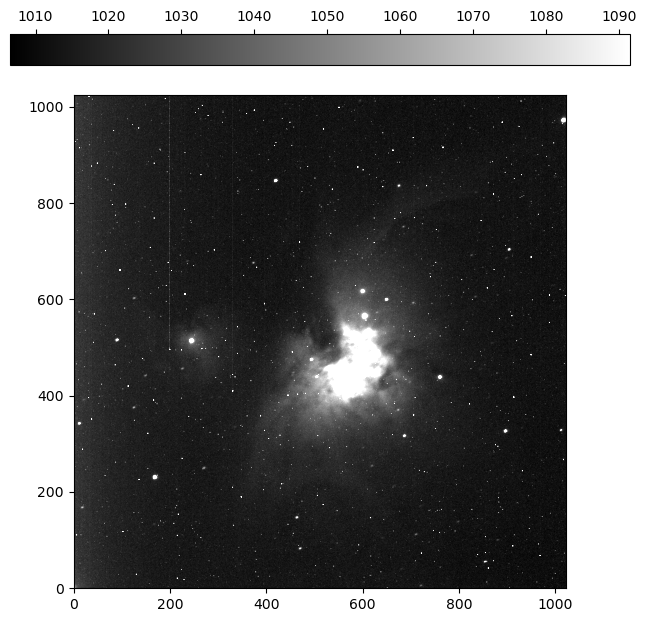

In [32]:
display_2d_array(master_blue,figsize=(8,8))

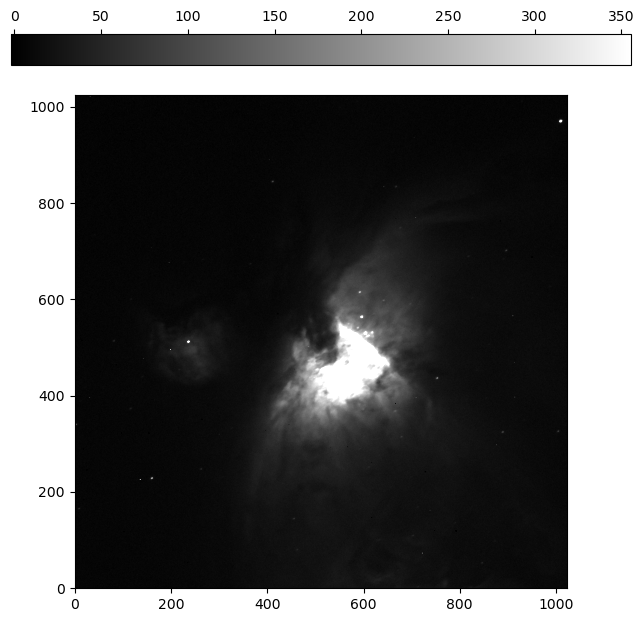

In [33]:
#Dark Subtraction
master_blue_prime = master_blue - master_dark
master_visible_prime = master_visible - master_dark
master_red_prime = master_red - master_dark
master_ha_prime = master_ha - master_dark

master_blue_flats_prime = master_blue_flats - master_dark
master_visible_flats_prime = master_visible_flats - master_dark
master_red_flats_prime = master_red_flats - master_dark
master_ha_flats_prime = master_ha_flats - master_dark

#display_2d_array(1 / (master_ha_prime - master_blue_prime),figsize=(8,8))
display_2d_array(master_ha_prime,figsize=(8,8))

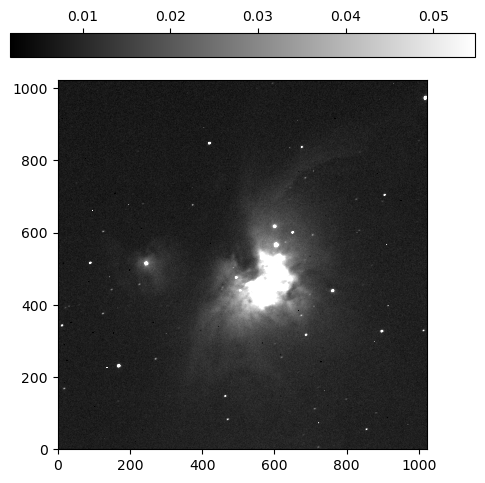

In [34]:
def flat_correction(master_image, master_flat):
    #maximum = np.max(master_flat)
    #const = 1/maximum 
    const = 1 / np.median(master_flat)
    master_flat_normalized = master_flat * const
    master_image = master_image/master_flat_normalized
    master_image = master_image*const
    return master_image

blue_science = flat_correction(master_blue_prime,master_blue_flats_prime)
visible_science = flat_correction(master_visible_prime,master_visible_flats_prime)
red_science = flat_correction(master_red_prime,master_red_flats_prime)
ha_science = flat_correction(master_ha_prime,master_ha_flats_prime)

save_array_to_fits_file(blue_science, 'blue_science.fits')
save_array_to_fits_file(visible_science, 'visible_science.fits')
save_array_to_fits_file(red_science, 'red_science.fits')
save_array_to_fits_file(ha_science, 'ha_science.fits')
display_2d_array(blue_science)

In [35]:
from PIL import Image

# Load blue, green, and red channels from FITS files
blue_data = fits.getdata('blue_science.fits')
green_data = fits.getdata('visible_science.fits')
red_data = fits.getdata('red_science.fits')

# Normalize the data to [0, 255] if necessary
blue_data = np.clip(blue_data, 0, 255).astype(np.uint8)
green_data = np.clip(green_data, 0, 255).astype(np.uint8)
red_data = np.clip(red_data, 0, 255).astype(np.uint8)

# Stack them into an RGB array
rgb_array = np.stack([red_data, green_data, blue_data], axis=-1)

# Convert to an image using Pillow and save or display it
rgb_image = Image.fromarray(rgb_array)
rgb_image.save('combined_image.png')
rgb_image.show()


In [36]:
from astropy.io import fits
import numpy as np

# Load the FITS files as NumPy arrays
red_image = fits.getdata('ha_science.fits')
green_image = fits.getdata('red_science.fits')
blue_image = fits.getdata('visible_science.fits')

# Optionally, normalize the images
def normalize_image(data, lower_percentile=1, upper_percentile=99):
    lower = np.percentile(data, lower_percentile)
    upper = np.percentile(data, upper_percentile)
    normalized_data = (data - lower) / (upper - lower) * 255
    return np.clip(normalized_data, 0, 255).astype(np.uint8)

red_image = normalize_image(red_image)
green_image = normalize_image(green_image)
blue_image = normalize_image(blue_image)


In [37]:
from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift

# Function to align two images using cross-correlation
def align_images_translation(image1, image2):
    # Calculate the shift between the images
    shift_yx, error, diffphase = phase_cross_correlation(image1, image2)
    print(f"Shift: {shift_yx}, Error: {error}")

    # Apply the shift to image2
    aligned_image2 = shift(image2, shift_yx)

    return aligned_image2

# Align green and blue channels to the red channel
aligned_green = align_images_translation(red_image, green_image)
aligned_blue = align_images_translation(red_image, blue_image)


Shift: [0. 0.], Error: 1.0
Shift: [0. 0.], Error: 1.0


In [38]:
from PIL import Image

# Stack the aligned channels into an RGB array
rgb_array = np.stack([red_image, aligned_green, aligned_blue], axis=-1)

# Convert to an image and display/save
rgb_image = Image.fromarray(rgb_array.astype(np.uint8))
rgb_image.show()  # Display the image
rgb_image.save('aligned_rgb_image.png')  # Save the image
